# Define canon for SMK paintings

In [2]:
#import requests
from PIL import Image
import os
import pandas as pd
import numpy as np
import datasets
from tqdm import tqdm
from datasets import Image as Image_ds # change name because of similar PIL module
from datasets import Dataset
from datasets import load_dataset
import urllib.parse
import json
import pickle
import requests
import matplotlib.pyplot as plt 
from sklearn.neighbors import NearestNeighbors
import re
import sys
sys.path.append(os.path.abspath(".."))
from src.utils import plot_neighbors

## Load smk data

We load the SMK data + metadata in a couple of different formats:

df = Pandas DataFrame with SMK metadata on paintings (i.e., smk type "Maleri", "Akvarel", "Miniature" and "Gouache"). It's mainly "Maleri" in this category, though.

metadata = JSON file with *all* metadata from the SMK API, not structured.

ds = HuggingFace dataset with same columns as pandas DF, but also a column storing a PIL image of the painting (mainly used here as it's easy to check the painting when it's stored in a ds)

In [35]:
# read df from csv 
data_path = os.path.join('..', 'data')
df = pd.read_pickle(os.path.join(data_path, 'all_paintings_subset.pkl'))

In [36]:
# load metadata json
json_path = os.path.join(data_path, 'all_paintings_metadata')

# Open and read the JSON file
with open(json_path, 'r') as file:
    metadata = json.load(file)

In [37]:
# load image data
ds = load_dataset("louisebrix/smk_all_paintings", split="train") # all the data is in the 'train' split

In [38]:
# add column with greyscale information from ds (i.e., whether the image is greyscale or not)
df['rgb'] = ds['rgb'] 

Besides the metadata we already have in our df, we need to extract some extra data from the metadata json we can use for defining a canon of paintings and add it to our df:

In [39]:
def extract_canon_info(item):

    ''''
    Get information on canon features from smk item
    '''

    content_keys = ['exhibitions',
                    'acquisition_date', 
                    'responsible_department', 
                    'documentation', 
                    'on_display', 
                    'current_location_name',
                    'literary_reference',
                    'object_history_note']

    content_data = {field: item.get(field, pd.NA) for field in content_keys}

    return content_data

In [40]:
data_dicts = []
for item in tqdm(metadata, total=len(metadata)):
    content_data = extract_canon_info(item)
    data_dicts.append(content_data)

data_df = pd.DataFrame(data_dicts)
df = pd.concat([df, data_df], axis=1)     

100%|██████████| 2085/2085 [00:00<00:00, 319690.14it/s]


In [41]:
df.head(5)

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,image,rgb,exhibitions,acquisition_date,responsible_department,documentation,on_display,current_location_name,literary_reference,object_history_note
0,KKSgb20565,1803-1861,1803,Udsigt fra Rundetårn over København til Freder...,H.G.F. Holm,[H.G.F. Holm],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/w3763b937_kk...,...,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...",color,[{'exhibition': 'Beyond the Light: Identity an...,1803-01-01T00:00:00Z,Den Kongelige Kobberstiksamling,"[{'title': 'Danske tegninger: en oversigt', 'a...",False,<NA>,<NA>,<NA>
1,KKSgb18206,1778-1841,1778,Mand med slæde,Sigmund Ferdinand Ritter von Perger,[Sigmund Ferdinand Ritter von Perger],1,Akvarel,"[Akvarel, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/ws859k68q_kk...,...,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...",color,<NA>,1787-01-01T00:00:00Z,Den Kongelige Kobberstiksamling,<NA>,False,<NA>,<NA>,<NA>
2,KKSgb17569,1799-1860,1799,Eksotisk fugl,Johan Christian Ernst Walter,[Johan Christian Ernst Walter],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/np193f181_kk...,...,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...",color,<NA>,1787-01-01T00:00:00Z,Den Kongelige Kobberstiksamling,<NA>,False,<NA>,<NA>,<NA>
3,KKSgb17570,1799-1860,1799,Eksotisk fugl,Johan Christian Ernst Walter,[Johan Christian Ernst Walter],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/hm50tx28p_kk...,...,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...",color,<NA>,1787-01-01T00:00:00Z,Den Kongelige Kobberstiksamling,<NA>,False,<NA>,<NA>,<NA>
4,KKSgb17568,1799-1860,1799,Fugl,Johan Christian Ernst Walter,[Johan Christian Ernst Walter],1,Gouache,"[Gouache, Tegning]",https://iip-thumb.smk.dk/iiif/jp2/pc289p10p_kk...,...,"{'path': None, 'bytes': b'\xff\xd8\xff\xe0\x00...",color,<NA>,1787-01-01T00:00:00Z,Den Kongelige Kobberstiksamling,<NA>,False,<NA>,<NA>,<NA>


In [42]:
# get exhibition venues to check how many are from smk
def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        venues = []
        for i in range(len(exhb_dict)):
            venue = exhb_dict[i].get('venue', pd.NA)
            venues.append(venue)
        return venues
    
    else:
        return pd.NA

In [43]:
venues_list = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['exhibition_venues'] = venues_list

If a painting has been in an exhibition at SMK it will be under 'Sølvgade' (the adress for SMK) in 'venues'

In [44]:
def check_smk(venues):
    if isinstance(venues, list):
        if any(isinstance(v, str) and 'Sølvgade' in v for v in venues):
            return True 
        else:
            return False 
    else:
        return False

In [45]:
smk_exhibitions = [check_smk(venues) for venues in df['exhibition_venues']]
df['smk_exhibitions'] = smk_exhibitions

In [169]:
def extract_enrichment_wiki_info(smk_id, session):

    '''
    Make calls to enrichment API and relevant extract information
    '''
    try:
        try:
            # enrichment API can't handle slashes in the smk_id as it sees them as part of the path, so they need to be encoded properly
            encoded_smk_id = urllib.parse.quote(smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()
        
        except Exception:
            # SMK API is case insensitive but Enrichment API is not, so try to make the smk_id uppercase in case this is why the request fails
            uppercase_smk_id = smk_id.upper()
            encoded_smk_id = urllib.parse.quote(uppercase_smk_id, safe='')
            enrichment_url = f'https://enrichment.api.smk.dk/api/enrichment/{encoded_smk_id}'
            enrichment_request = session.get(enrichment_url)
            enrichment_json = enrichment_request.json()

        wiki_data = pd.NA
        for item in enrichment_json:
            if item.get('type') == 'wikidata':
                
                wiki_data = item.get('data', pd.NA).get('wikidata_link_da_s', pd.NA)
                
                break

    # if request still fails, print error message and append NA for this object
    except Exception as e:
        #print(f"Error fetching enrichment API data: {enrichment_url}")
        return pd.NA

    return wiki_data

In [170]:
# not sure we need this (and code takes some time to run)
#wiki_data_list = [extract_enrichment_wiki_info(smk_id, session) for smk_id in df['smk_id']]
#df['wiki_data'] = wiki_data_list
#df[~df['wiki_data'].isna()]

Add column with information about whether an exhibition was called something specific with 'gold'

In [46]:
golden = ['gold', 'guld']

def exhb_venues(exhb_dict):
    if exhb_dict is not pd.NA:
        titles = []
        for i in range(len(exhb_dict)):
            title = exhb_dict[i].get('exhibition', None)

            if title:
                # Check if any keyword matches (case-insensitive)
                if any(re.search(keyword, title.lower()) for keyword in golden):
                    titles.append(title)

        return titles if titles else pd.NA
    else:
        return pd.NA 

In [47]:
golden_titles = [exhb_venues(exhb_dict) for exhb_dict in df['exhibitions']]
df['golden_titles'] = golden_titles
len(df['golden_titles'].value_counts())

80

In [48]:
# convert columns to 0/1 instead of True/False
df['smk_exhibitions'] = df['smk_exhibitions']*1
df['on_display'] = df['on_display']*1

Create variable on whether the artwork has been exhibited anywhere:

In [49]:
def check_exhibitions(exhibitions):
    if isinstance(exhibitions, list):
        return 1 
    else:
        return 0 

In [50]:
exhibitions = [check_exhibitions(exb) for exb in df['exhibitions']]
df['exb_canon'] = exhibitions

Create canon variable based on how many books an artwork is mentioned in:

In [51]:
docs_len = []
for docs in df['documentation']:
    try:
        docs_len.append(len(docs))
    
    except:
        docs_len.append(0)
df['docs_len'] = docs_len

In [52]:
# define some threshold
docs_canon = [1 if i > 7 else 0 for i in df['docs_len']]
df['docs_canon'] = docs_canon

In [53]:
df['docs_canon'].value_counts()

docs_canon
0    1936
1     149
Name: count, dtype: int64

In [54]:
df.sort_values(by='docs_len', ascending=False).head(5)

,smk_id,period,start_year,title,first_artist,all_artists,num_artists,main_type,all_types,image_thumbnail,...,on_display,current_location_name,literary_reference,object_history_note,exhibition_venues,smk_exhibitions,golden_titles,exb_canon,docs_len,docs_canon
196,KMS586,1775,1775,Den sårede Filoktet,Nicolai Abildgaard,[Nicolai Abildgaard],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/8910jx49s_KM...,...,1,Sal 217B,"[Motiv fra Sofokles, ""Philoctetes""]",[I kunstnerens eje indtil hans død i 1809. Den...,"[Sølvgade, Sølvgade, Louvre, Hamburger Kunstha...",1,"[The golden age of Danish painting, The golden...",1,71,1
171,KMS412,1843,1843,En dansk kyst. Motiv fra Kitnæs ved Roskilde F...,Johan Thomas Lundbye,[Johan Thomas Lundbye],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/df65vb95j_KM...,...,1,Sal 217F,<NA>,<NA>,"[Sølvgade, Petit Palais, Ateneum, Helsinki, Na...",1,"[""Danish Golden Age"" Petit Palais, Guldalderku...",1,41,1
352,KMS3123,1815,1815,Udsigt gennem tre buer i Colosseums tredje sto...,C.W. Eckersberg,[C.W. Eckersberg],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/hm50tw13v_KM...,...,1,Sal 217C,<NA>,[Solgt 1854 på Eckersbergs auktion til Profess...,"[Petit Palais, Sølvgade, Sølvgade, Sølvgade, A...",1,"[""Danish Golden Age"" Petit Palais, Her i Itali...",1,40,1
126,KMS3236,1837,1837,Et selskab af danske kunstnere i Rom,Constantin Hansen,[Constantin Hansen],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/z603r1675_km...,...,1,Sal 218B,<NA>,<NA>,"[Petit Palais, Sølvgade, Sølvgade, Sølvgade, N...",1,"[""Danish Golden Age"" Petit Palais, Her i Itali...",1,38,1
191,KMS844,1836,1836,Parti af Østerbro i morgenbelysning,Christen Købke,[Christen Købke],1,Maleri,[Maleri],https://iip-thumb.smk.dk/iiif/jp2/8336h501h_km...,...,1,Sal 217D,<NA>,<NA>,"[Sølvgade, Nationalmuseum, Stockholm, Sølvgade...",1,"[Dansk guldålder / The Danish Golden Age, ""Dan...",1,35,1


A quick manual inspection (= googling) of the paintings with most mentions verify the method, they look well-known

In [55]:
# checking number of paintings that are currently on display at SMK but does not have any data on exhibitions
len(df[(df['on_display'] == 1) & (df['exb_canon'] == 0)])

33

In [56]:
# check overlap between canon categories:
len(df[(df['docs_canon'] == 0) & (df['exb_canon'] == 1)])

571

Quite a lot of paintings are not mentioned in a lot of litterature, though, but are exhibited.
Probably very dependant on the threshold we set for our docs_canon

In [57]:
len(df[(df['docs_canon'] == 1) & (df['exb_canon'] == 0)])

6

On the other hand, most works with +7 mentions in litterature have been exhibited

Create canon "gross-list" if the artwork is in any of the defined canon categories:

In [58]:
canon = []
for idx, row in df.iterrows():
    if row['exb_canon'] or row['on_display'] == 1:
        canon.append('canon')
    else:
        canon.append('other')

df['canon'] = canon
df['canon'].value_counts()

canon
other    1338
canon     747
Name: count, dtype: int64

### Check correlations

In [59]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon'],
      dtype='object')

In [60]:
n_exhibitions_list = []
n_golden_titles_list = []

for idx, row in df.iterrows():    
    n_exhibitions_list.append(len(row['exhibition_venues']) if isinstance(row['exhibition_venues'], list) else pd.NA)
    n_golden_titles_list.append(len(row['golden_titles']) if isinstance(row['golden_titles'], list) else pd.NA)

In [61]:
df['n_exhibitions'] = n_exhibitions_list
df['n_golden_titles'] = n_golden_titles_list 

In [62]:
def n_smk_venues(venues):

    n_venues = 0

    if isinstance(venues, list):
        for v in venues:
            if isinstance(v, str) and v == 'Sølvgade':
                n_venues += 1
            else: 
                n_venues += 0
    else:
        n_venues += 0

    return n_venues

In [63]:
n_smk_exhibitions = [n_smk_venues(venues) for venues in df['exhibition_venues']]
df['n_smk_exhibitions'] = n_smk_exhibitions

In [64]:
no_na_df = df.fillna(0)

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_85663/2020816724.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  no_na_df = df.fillna(0)


In [65]:
def plot_correlation(target_column, columns):
    fig, ax = plt.subplots(1, 2, figsize = (10,4))
    columns.remove(target_column)

    for i, v in enumerate(columns):
        ax[i].scatter(no_na_df[target_column], no_na_df[v])
        ax[i].set_title(f'Correlation coef: {round(no_na_df[target_column].corr(no_na_df[v]), 3)}')
        ax[i].set_xlabel(target_column)
        ax[i].set_ylabel(v)

    fig.show()

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_85663/2206682411.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


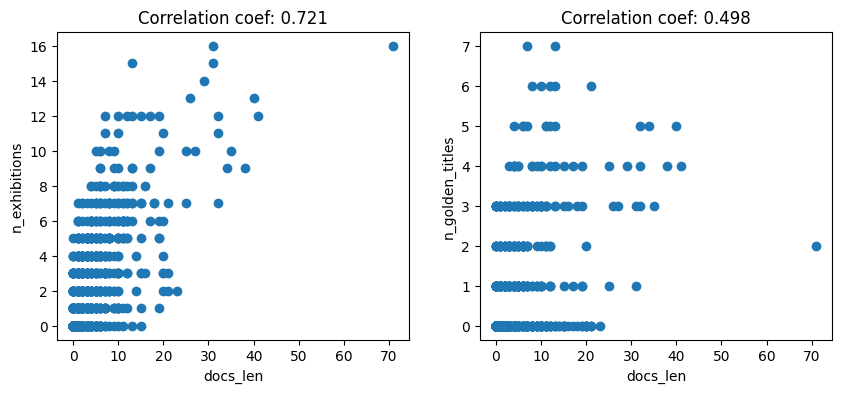

In [66]:
columns = ['docs_len',
 'n_exhibitions',
 'n_golden_titles']
plot_correlation('docs_len', columns)

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_85663/2206682411.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


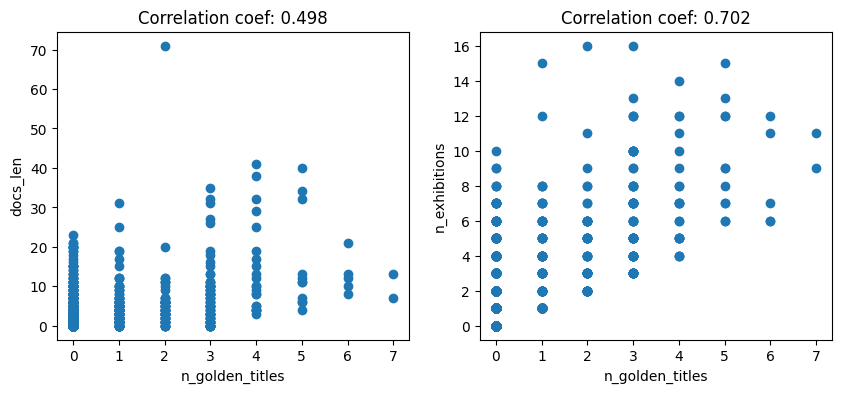

In [67]:
columns = ['docs_len',
 'n_exhibitions',
 'n_golden_titles']
plot_correlation('n_golden_titles', columns)

In [69]:
# check corr variables

df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)

corr = df_corr.corr()
corr.style.background_gradient(cmap='coolwarm')

/var/folders/m8/6qm1yrz575b68s5y27_5z0jc33spwq/T/ipykernel_85663/625316017.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_corr = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].fillna(0)


,n_exhibitions,n_golden_titles,n_smk_exhibitions,on_display
n_exhibitions,1.000000,0.702335,0.776663,0.501198
n_golden_titles,0.702335,1.000000,0.649684,0.376438
n_smk_exhibitions,0.776663,0.649684,1.000000,0.529895
on_display,0.501198,0.376438,0.529895,1.000000


In [70]:
# check corr variables

df_corr_nona = df[['n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions', 'on_display']].dropna(how='any')

corr = df_corr_nona.corr()
corr.style.background_gradient(cmap='coolwarm')

,n_exhibitions,n_golden_titles,n_smk_exhibitions,on_display
n_exhibitions,1.000000,0.611388,0.692386,0.517637
n_golden_titles,0.611388,1.000000,0.463358,0.400167
n_smk_exhibitions,0.692386,0.463358,1.000000,0.516856
on_display,0.517637,0.400167,0.516856,1.000000


In [113]:
df = df.query('main_type == "Maleri"')
indices = df.index.tolist()
df.reset_index(drop=True, inplace=True)
ds = ds.select(indices)

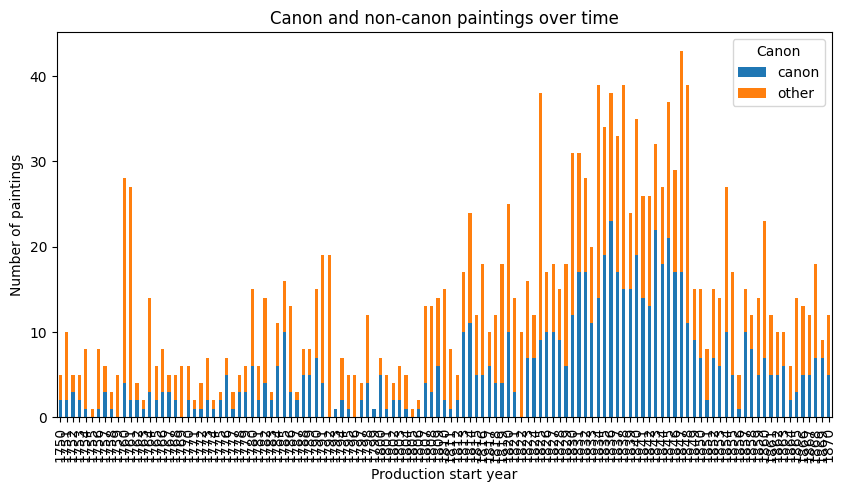

In [117]:
df.groupby(['start_year', 'canon']).size().unstack().plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Canon and non-canon paintings over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Canon', loc='upper right')
plt.show()

In [1]:
groupobject = df.groupby(['start_year', 'exb_canon']).size().unstack()
ax = groupobject.plot(kind='bar', stacked=True, figsize=(10, 5))

N = 5
ax.set_xticks(range(0, len(groupobject), N))
ax.set_xticklabels(groupobject.index[::5])

plt.title('Exhibited and non-exhibited paintings over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Exhibition status', loc='upper right')
plt.show()

NameError: name 'df' is not defined

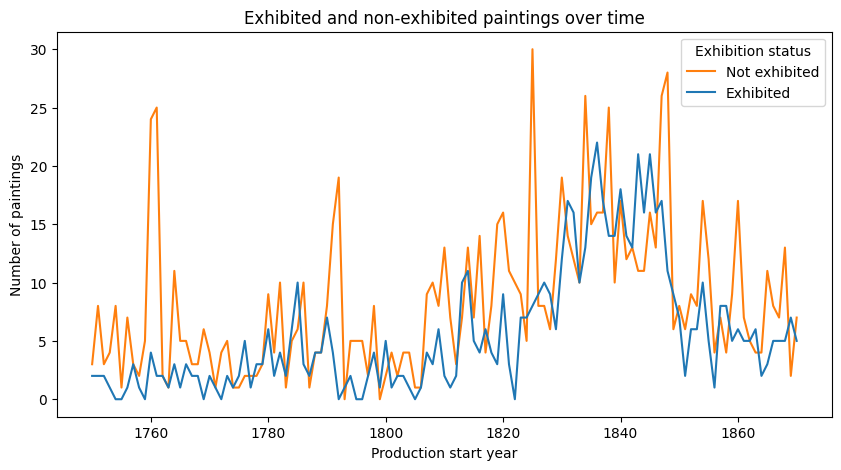

In [115]:
grouping = df.groupby(['start_year', 'exb_canon']).size().unstack().fillna(0)
plt.figure(figsize=(10, 5))
plt.plot(grouping.index, grouping[0], label='Not exhibited', color='#ff7f0e') # specify colors to match first plot
plt.plot(grouping.index, grouping[1], label='Exhibited', color='#1f77b4')
plt.title('Exhibited and non-exhibited paintings over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Exhibition status', loc='upper right')
plt.show()

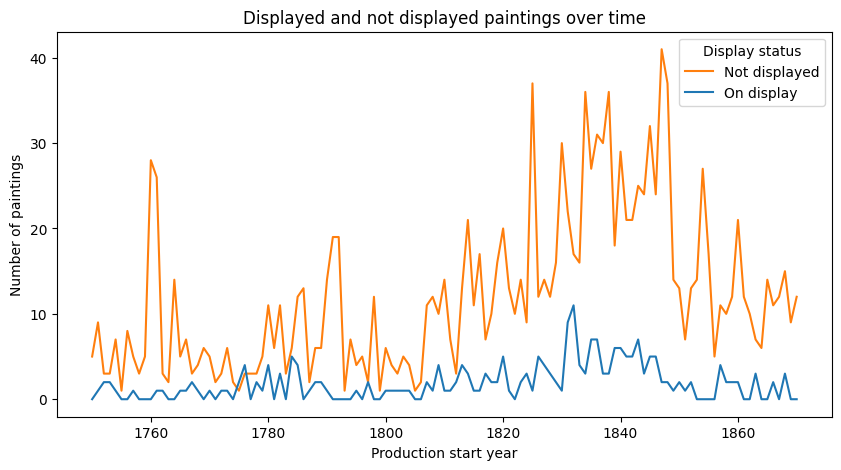

In [116]:
grouping = df.groupby(['start_year', 'on_display']).size().unstack().fillna(0)
plt.figure(figsize=(10, 5))
plt.plot(grouping.index, grouping[0], label='Not displayed', color='#ff7f0e') # specify colors to match first plot
plt.plot(grouping.index, grouping[1], label='On display', color='#1f77b4')
plt.title('Displayed and not displayed paintings over time')
plt.xlabel('Production start year')
plt.ylabel('Number of paintings')
plt.legend(title='Display status', loc='upper right')
plt.show()

In [118]:
df.columns

Index(['smk_id', 'period', 'start_year', 'title', 'first_artist',
       'all_artists', 'num_artists', 'main_type', 'all_types',
       'image_thumbnail', 'gender', 'birth_death', 'nationality', 'history',
       'artist_roles', 'creator_roles', 'num_creators', 'techniques',
       'enrichment_url', 'content_person', 'has_text', 'colors',
       'geo_location', 'entropy', 'tags_en', 'image', 'rgb', 'exhibitions',
       'acquisition_date', 'responsible_department', 'documentation',
       'on_display', 'current_location_name', 'literary_reference',
       'object_history_note', 'exhibition_venues', 'smk_exhibitions',
       'golden_titles', 'exb_canon', 'docs_len', 'docs_canon', 'canon',
       'n_exhibitions', 'n_golden_titles', 'n_smk_exhibitions'],
      dtype='object')

In [119]:
df['exb_canon']

0       1
1       1
2       1
3       1
4       0
       ..
1685    1
1686    1
1687    0
1688    0
1689    0
Name: exb_canon, Length: 1690, dtype: int64

In [68]:
# write new df with canon info to disk
data_path = os.path.join('..', 'data')
df.to_pickle(os.path.join(data_path, 'all_paintings_canonized.pkl'))